In [1]:
from statsbombpy import sb
import pandas as pd
import numpy as np
import networkx as nx             ## version 1.11
from collections import Counter
import matplotlib.pyplot as plt   ## version 2.2.3

import warnings
warnings.filterwarnings('ignore')

# Load Data

In [2]:
sb.competitions().iloc[[18]]

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
18,43,3,International,FIFA World Cup,male,False,True,2018,2022-09-05T17:17:56.670896,2021-06-13T16:17:31.694,None,2022-09-05T17:17:56.670896


In [3]:
# list of matches from 2018 World Cup
matches_list = sb.matches(competition_id=43, season_id=3)['match_id'].to_list()

# Use statsbomb API to return events from all World Cup matches:
for count, id in enumerate(matches_list):
    if count==0:
        events = sb.events(match_id=id)
    else:
        events = events.append(sb.events(match_id=id), ignore_index=True)
        
# Filter events to retain only regular passes:
passes = events.loc[(events['type']=='Pass')&(events['play_pattern']=='Regular Play')]

In [6]:
# Convert location data from arrays into coordinates
passes['x'] = passes.apply(lambda n: n['location'][0] , axis=1)
passes['y'] = passes.apply(lambda n: n['location'][1] , axis=1)
passes['pass_end_x'] = passes.apply(lambda n: n['pass_end_location'][0] , axis=1)
passes['pass_end_y'] = passes.apply(lambda n: n['pass_end_location'][1] , axis=1)

# Filter columns to those relevant to passes
passes = passes[['duration','id',
       'match_id','x','y','pass_end_x','pass_end_y',
       'pass_aerial_won', 'pass_angle', 'pass_assisted_shot_id',
       'pass_backheel', 'pass_body_part', 'pass_cross', 'pass_cut_back',
       'pass_goal_assist', 'pass_height', 'pass_length',
       'pass_outcome', 'pass_recipient', 'pass_shot_assist', 'pass_switch',
       'pass_type', 'player', 'player_id','play_pattern',
       'position', 'possession_team', 'possession_team_id',
       'related_events', 'team', 'type']].reset_index(drop=True)

# convert player_id data type (float) into integer
passes['player_id'] = passes['player_id'].astype(int)

In [8]:
passes['match_id'].value_counts()

8657    840
7565    795
7578    753
8652    694
7544    681
       ... 
7536    412
7566    411
7586    396
7571    357
7577    346
Name: match_id, Length: 64, dtype: int64

## Create Graph Metrics:

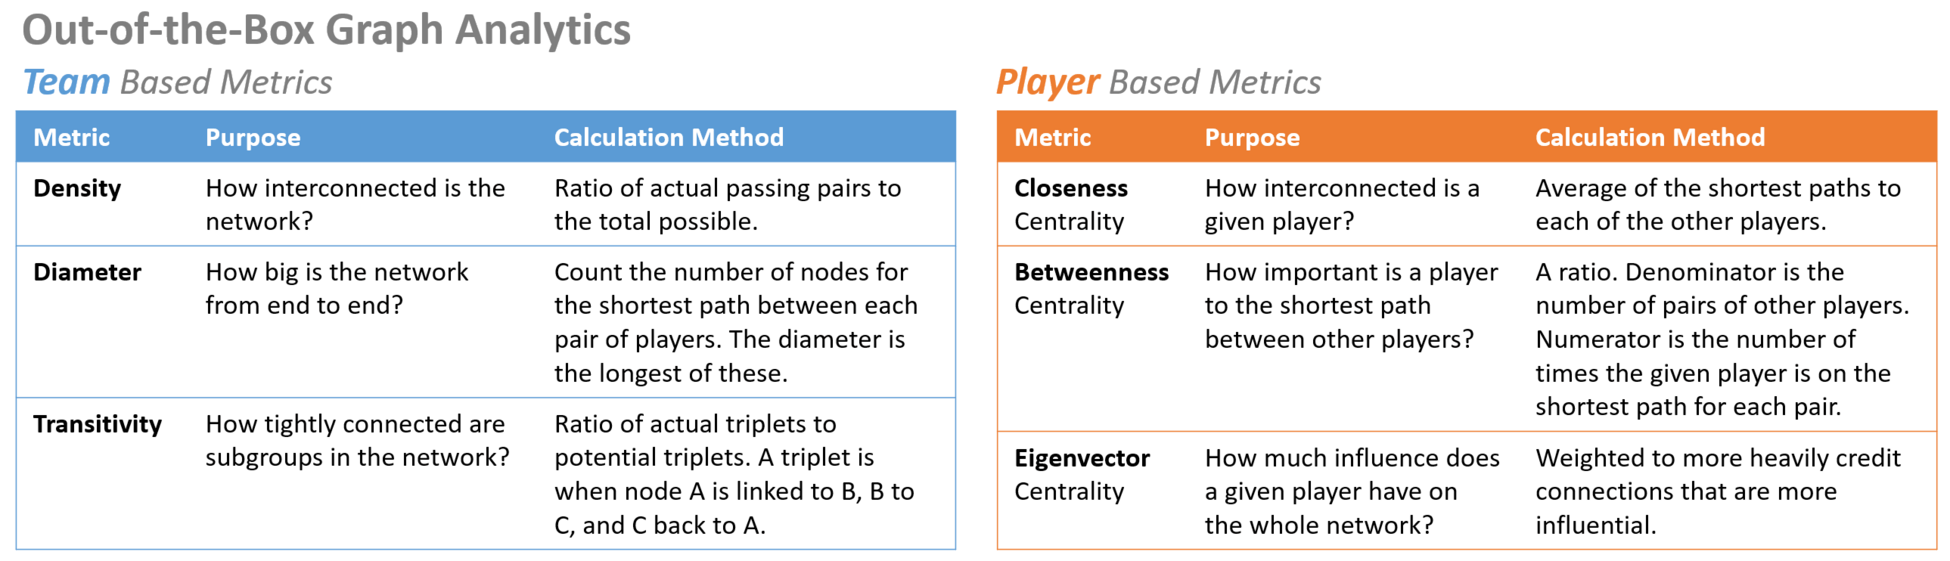

## Graph Theory Prep

Prep for calculcating team and player graph metrics.

In [9]:
# Build a list of all teams
teams_list = passes['team'].unique().tolist()
#print(all_teams)

# Create blank dataframe for team and player metrics
team_metrics = pd.DataFrame(columns=['team', 'density', 'transitivity', 
                                     'avg goals', 'avg goals conceded', 
                                     'avg point diff'])

player_metrics = pd.DataFrame(columns=['team', 'player', 'degree', 'closeness', 
                                       'betweenness', 'ev_centrality' ])

# Prepare dictionary of avg goals for and against each team (manually created from official scores)
avg_goals_for = {'Australia': .67, 'Peru':.67, 'Iceland':.67, 'Nigeria':1.0, 
                 'Brazil':1.6, 'Serbia':.67, 'Denmark':.75, 'Croatia':2., 
                 'Portugal':1.5, 'Iran':.67, 'Sweden':1.2, 'Mexico':.75, 
                 'Costa Rica':.67, 'Germany':.67, 'Spain':1.75, 'Russia':2.2, 
                 'Egypt':.67, 'Switzerland':1.25, 'Tunisia':1.67, 'Panama':.67, 
                 'Belgium':2.29, 'England':1.71, 'France':2.0, 'Uruguay':1.4, 
                 'Argentina':1.5, 'Japan':1.5, 'South Korea':1., 'Morocco':.67, 
                 'Saudi Arabia':.67, 'Colombia':1.5, 'Poland':.67, 
                 'Senegal':1.33}

avg_goals_against = {'Australia': 1.67, 'Peru':.67, 'Iceland':1.67, 
                     'Nigeria':1.33, 'Brazil':.6, 'Serbia':1.33, 'Denmark':.5, 
                     'Croatia':1.29, 'Portugal':1.5, 'Iran':.67, 'Sweden':.8, 
                     'Mexico':1.5, 'Costa Rica':1.67, 'Germany':1.33, 
                     'Spain':1.5, 'Russia':1.4, 'Egypt':2.0, 'Switzerland':1.25, 
                     'Tunisia':2.67, 'Panama':3.67, 'Belgium':.86, 
                     'England':1.14, 'France':0.86, 'Uruguay':.6, 
                     'Argentina':2.25, 'Japan':1.75, 'South Korea':1., 
                     'Morocco':1.33, 'Saudi Arabia':2.33, 'Colombia':.75, 
                     'Poland':1.67, 'Senegal':1.33}

# Dictionary used in shading nodes (lighter to darker from backs, to midfield, to forwards)
position_dict = {'Goalkeeper':1, 'Right Back':10, 'Right Center Back':10, 
                 'Center Back':10, 'Left Center Back': 10, 'Left Back':10, 
                 'Right Wing Back':10, 'Left Wing Back':10, 
                 'Right Defensive Midfield':15, 'Center Defensive Midfield':15, 
                 'Left Defensive Midfield':15, 'Right Midfield':15, 
                 'Right Center Midfield':15, 'Center Midfield':15,
                 'Left Center Midfield':15, 'Left Midfield':15, 'Right Wing':25, 
                 'Right Attacking Midfield':15, 'Center Attacking Midfield':15, 
                 'Left Attacking Midfield':15, 'Left Wing':25, 
                 'Right Center Forward':25, 'Center Forward':25,
                  'Left Center Forward':25, 'Secondary Striker':30}

## Build Graphs & Calculate Metrics

Build pass graphs and metrics for each team and player. Some teams have disconnected graphs. This creates errors when calculating diameter. So not calculating diameter.

The NetworkX python library is used to easily build graphs and calculate graph metrics. NetworkX documentation is available at https://networkx.org/documentation/stable/index.html.

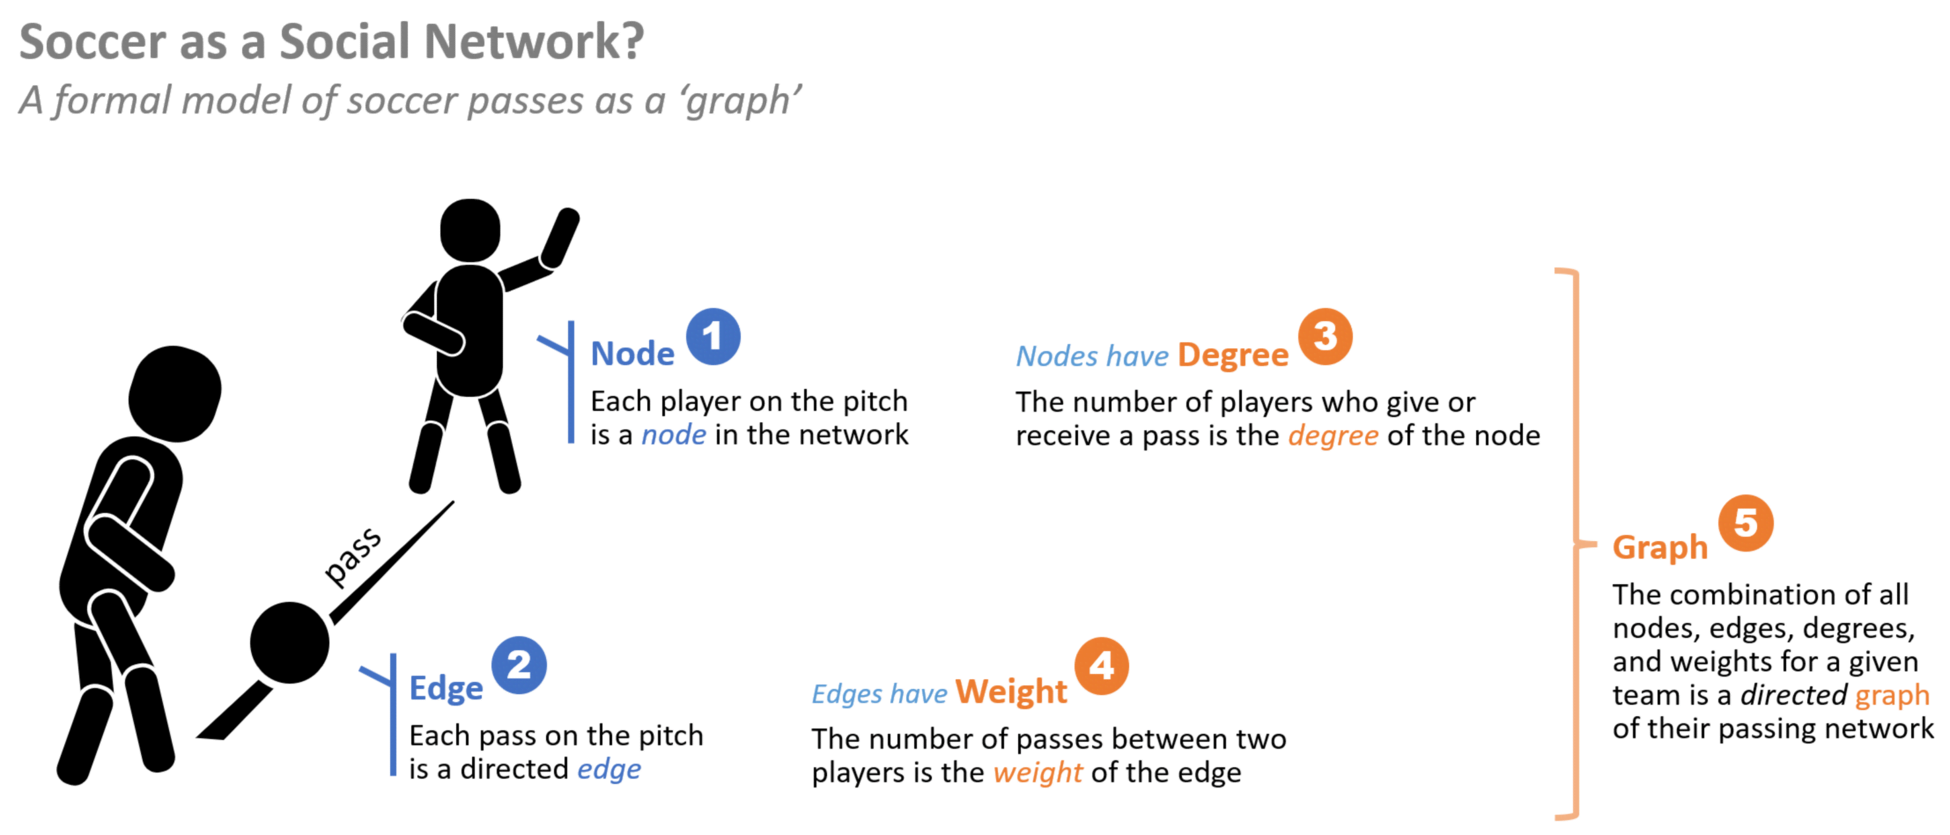

In [10]:
for team in teams_list:
    
    # create passing df for a given team
    team_df = passes[passes.team.eq(team)]
    #print("Full Count:", len(team_df.index))
    
    # drop rows with blank pass recepient
    team_df['pass_recipient'].replace('', np.nan, inplace=True)
    team_df.dropna(subset=['pass_recipient'], inplace=True)
    #print("New Count:", len(team_df.index))
    
    # create list of all edges for given team
    edges = []
    for index, row in team_df.iterrows():
        edges.append((row.player, row.pass_recipient))
        
    # create graph from edges list
    graph = nx.DiGraph((x, y, {'weight': v}) for (x, y), v in Counter(edges).items())
    #print(*graph.edges(data=True), sep='\n')
    
    #Append to team table
    team_metrics = team_metrics.append({
                    'team' : team, 'density' : nx.density(graph), 'transitivity': nx.transitivity(graph),
                    'avg goals':avg_goals_for[team] , 
                    'avg goals conceded':avg_goals_against[team] , 
                    'avg point diff': avg_goals_for[team] - avg_goals_against[team]}, ignore_index=True)
    
    # Append player metrics
    for player in list(graph.nodes()):
        player_metrics = player_metrics.append({
                    'team' : team, 'player' : player, 'degree' : graph.degree(player), 
                    'closeness': nx.closeness_centrality(graph)[player], 
                    'betweenness': nx.betweenness_centrality(graph)[player], 
                    'ev_centrality': nx.eigenvector_centrality(graph)[player]}, ignore_index=True)

In [11]:
print("Team Metrics:\n", team_metrics.head())
print("\n\nPlayer Metrics:\n", player_metrics.head())

Team Metrics:
          team   density  transitivity  avg goals  avg goals conceded  \
0      Brazil  0.801471      0.837227       1.60                0.60   
1  Costa Rica  0.532164      0.674762       0.67                1.67   
2       Egypt  0.654167      0.742647       0.67                2.00   
3     Uruguay  0.622807      0.737838       1.40                0.60   
4      Mexico  0.593567      0.735940       0.75                1.50   

   avg point diff  
0            1.00  
1           -1.00  
2           -1.33  
3            0.80  
4           -0.75  


Player Metrics:
      team                            player degree  closeness  betweenness  \
0  Brazil          Thiago Emiliano da Silva     30   0.888889     0.024826   
1  Brazil             Fágner Conserva Lemos     28   0.888889     0.021677   
2  Brazil  José Paulo Bezzera Maciel Júnior     27   0.842105     0.013145   
3  Brazil          Carlos Henrique Casimiro     29   0.888889     0.018678   
4  Brazil    Marcelo Vi

## Pearson Coefficient of Correlation Heatmap

Build heatmap to identify graph metrics that most correlate with team performance. From the plot we see that transitivity and avg point difference have the highest correlation.

<AxesSubplot: >

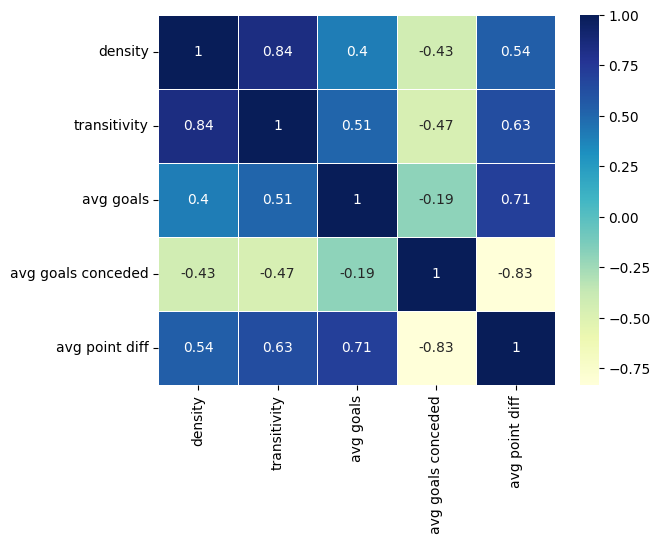

In [12]:
import seaborn as sb

pearsoncorr = team_metrics.corr(method='pearson')
sb.heatmap(pearsoncorr, 
            xticklabels=pearsoncorr.columns,
            yticklabels=pearsoncorr.columns,
            cmap='YlGnBu',
            annot=True,
            linewidth=0.5)

## Rank Order Teams

Rank order by transitivity which is a measure of how interconnected the network of passes are between players.

In [13]:
team_metrics.sort_values(by=['transitivity'], inplace=True, ascending=False)
team_metrics.reset_index(drop=True)

,team,density,transitivity,avg goals,avg goals conceded,avg point diff
0,Brazil,0.801471,0.837227,1.60,0.60,1.00
1,England,0.666667,0.784546,1.71,1.14,0.57
2,Colombia,0.625731,0.773419,1.50,0.75,0.75
3,Croatia,0.580952,0.750890,2.00,1.29,0.71
4,France,0.580952,0.745728,2.00,0.86,1.14
5,Peru,0.599265,0.742806,0.67,0.67,0.00
6,Egypt,0.654167,0.742647,0.67,2.00,-1.33
7,Spain,0.705882,0.741704,1.75,1.50,0.25
8,Portugal,0.663399,0.741132,1.50,1.50,0.00
9,Belgium,0.683333,0.739397,2.29,0.86,1.43


## Rank Order Players

Rank order by closeness and degree which is a measure of how interconnected the network of passes are between players.

In [14]:
player_metrics.sort_values(by=['closeness', 'degree'], inplace=True, ascending=[False, False])
player_metrics.reset_index(drop=True)
player_metrics.head()

,team,player,degree,closeness,betweenness,ev_centrality
340,Germany,Toni Kroos,37,1.000000,0.077944,0.320356
424,Argentina,Javier Alejandro Mascherano,36,1.000000,0.081357,0.312014
37,Egypt,Abdalla Mahmoud El Said Bekhit,28,1.000000,0.054609,0.333943
521,Australia,Mathew Leckie,26,1.000000,0.110710,0.361178
402,England,John Stones,38,0.952381,0.039325,0.283557


In [15]:
player_metrics.tail()

,team,player,degree,closeness,betweenness,ev_centrality
333,Serbia,Luka Jović,1,0.377778,0.0,1.391308e-02
542,Russia,Vladimir Granat,2,0.000000,0.0,3.986964e-09
337,Serbia,Aleksandar Prijović,1,0.000000,0.0,1.515060e-08
417,England,Daniel Nii Tackie Mensah Welbeck,1,0.000000,0.0,4.607971e-12
494,Iceland,Albert Gudmundsson,1,0.000000,0.0,1.057419e-08


## Team Analysis

Create metrics and analysis for any given team.

Create features for last names to use for plots with the passes dataframe.

In [17]:
passes['passer'] = passes['player'].str.split().str[-1]
passes['recipient'] = passes['pass_recipient'].str.split().str[-1]
passes['downfield_dist'] = passes['pass_length'] * np.cos(passes['pass_angle'])

## Create List of Edges

Build a list of all passes which will be used to define the edges in a weighted directed graph.

In [35]:
team = "Panama"

# Create passing df for a given team
team_df = passes[passes.team.eq(team)]
print("Full Count:", len(team_df.index))

# Use to manually create list
#print(team_df['player'].unique())

# Create list of starters excluding Goal Keeper
Brazil = ['Fágner Conserva Lemos', 'Thiago Emiliano da Silva', 'João Miranda de Souza Filho', 
          'Filipe Luís Kasmirski', 'Carlos Henrique Casimiro', 'José Paulo Bezzera Maciel Júnior', 
          'Willian Borges da Silva', 'Philippe Coutinho Correia', 'Neymar da Silva Santos Junior', 
          'Gabriel Fernando de Jesus']

Panama = ['Adolfo Abdiel Machado', 'Román Aureliano Torres Morcillo', 
          'Fidel Escobar Mendieta', 'Luis Carlos Ovalle Victoria',
          'Gabriel Enrique Gómez Girón', 'Aníbal Cesis Godoy',
          'Ricardo Guardia Avila', 'José Luis Rodríguez Francis',
          'Edgar Yoel Bárcenas Herrera', 'Gabriel Arturo Torres Tejada']

Full Count: 511


In [36]:
edges = []
for index, row in team_df.iterrows():
    if row.player in Panama and row.pass_recipient in Panama:
        edges.append((row.player, row.pass_recipient))
    else:
        pass

## Build Graph from Edges

Use NetworkX to create directed and weighted graph.

In [37]:
graph = nx.DiGraph((x, y, {'weight': v}) for (x, y), v in Counter(edges).items())

## Print Team Metrics

In [38]:
print(team)
print("Total number of nodes: ", int(graph.number_of_nodes())) 
print("Total number of edges: ", int(graph.number_of_edges())) 
print("Network density:", nx.density(graph))
print("Network diameter:", nx.diameter(graph))
print("Triadic closure:", nx.transitivity(graph))

Panama
Total number of nodes:  10
Total number of edges:  63
Network density: 0.7
Network diameter: 2
Triadic closure: 0.7651933701657458


## Calculate Network Metrics by Player

In [39]:
# Create dataframe to hold player metrics for given team
player_metrics = pd.DataFrame(columns=['team', 'player', 'degree', 'closeness', 'betweenness', 'ev_centrality', 'net_score' ])

# Build metrics for each player
for player in list(graph.nodes()):
    #print(player)
    player_metrics = player_metrics.append({'team' : team, 'player' : player, 
                                            'degree' : graph.degree(player), 
                                            'closeness': nx.closeness_centrality(graph)[player], 
                                            'betweenness': nx.betweenness_centrality(graph)[player], 
                                            'ev_centrality': nx.eigenvector_centrality(graph)[player],
                                            'net_score': nx.eigenvector_centrality(graph)[player] + (5*nx.betweenness_centrality(graph)[player] )},
                                            ignore_index=True)

player_metrics

,team,player,degree,closeness,betweenness,ev_centrality,net_score
0,Panama,Fidel Escobar Mendieta,14,0.750000,0.064352,0.273018,0.594777
1,Panama,Aníbal Cesis Godoy,16,0.900000,0.056481,0.389532,0.671940
2,Panama,Gabriel Enrique Gómez Girón,16,0.900000,0.049537,0.361986,0.609672
3,Panama,Román Aureliano Torres Morcillo,10,0.692308,0.008333,0.264775,0.306441
4,Panama,José Luis Rodríguez Francis,15,0.900000,0.106713,0.367439,0.901003
5,Panama,Edgar Yoel Bárcenas Herrera,16,1.000000,0.064120,0.402389,0.722991
6,Panama,Gabriel Arturo Torres Tejada,9,0.750000,0.000000,0.306081,0.306081
7,Panama,Luis Carlos Ovalle Victoria,6,0.562500,0.000000,0.097396,0.097396
8,Panama,Adolfo Abdiel Machado,11,0.692308,0.010648,0.271620,0.324861
9,Panama,Ricardo Guardia Avila,13,0.750000,0.014815,0.314180,0.388254


In [40]:
player_metrics.describe().T

,count,mean,std,min,25%,50%,75%,max
closeness,10.0,0.789712,0.131674,0.562500,0.706731,0.750000,0.900000,1.000000
betweenness,10.0,0.037500,0.035938,0.000000,0.008912,0.032176,0.062211,0.106713
ev_centrality,10.0,0.304842,0.088642,0.097396,0.271970,0.310130,0.366076,0.402389
net_score,10.0,0.492342,0.245139,0.097396,0.311046,0.491515,0.656373,0.901003


## Add Node Attributes for Custom Plots

Add node attributes for avg pass length, position_id, and downfield_dist to be used in building out custome graph plots.

In [42]:
# Create scale based on position -- defensive backs are lower nums and forwards are higher
passes['position_scale'] = passes.apply(lambda x: position_dict[x.position], axis=1)

# add node attributes for avg pass length, position_id, and downfield_dist
for p in list(graph.nodes()):
    #print(player)
    graph.nodes[p]['pass_length'] = passes[passes.player.eq(p)].pass_length.mean()
    graph.nodes[p]['position_scale'] = int((round(passes[passes.player.eq(p)].position_scale.mean())/5.0)*5.0)
    graph.nodes[p]['downfield_distance'] = passes[passes.player.eq(p)].downfield_dist.mean()
    graph.nodes[p]['ev_centrality'] = player_metrics[player_metrics.player.eq(p)].ev_centrality.mean()
    graph.nodes[p]['net_score'] = player_metrics[player_metrics.player.eq(p)].net_score.mean()
    graph.nodes[p]['degree'] = player_metrics[player_metrics.player.eq(p)].degree.mean()
    
print('pass_length', [nx.get_node_attributes(graph, 'pass_length')[v] for v in graph])
print('position_scale', [nx.get_node_attributes(graph, 'position_scale')[v] for v in graph])
print('downfield_distance', [nx.get_node_attributes(graph, 'downfield_distance')[v] for v in graph])
print('pass_length', [nx.get_node_attributes(graph, 'pass_length')[v] for v in graph])

pass_length [26.76710700454545, 19.080754680000002, 23.56360541, 27.686281548387097, 16.132100366666666, 16.16225156511628, 13.560879, 23.360591833333334, 18.5525266, 22.4693775375]
position_scale [11, 15, 15, 10, 25, 25, 25, 10, 10, 16]
downfield_distance [14.54545438980685, 1.3076922474783697, 5.616666612569956, 19.290322597879825, -1.1944443248124104, 1.581395368006536, -3.3333330533761565, 9.833333743542143, 8.466666447963963, 7.437499681941895]
pass_length [26.76710700454545, 19.080754680000002, 23.56360541, 27.686281548387097, 16.132100366666666, 16.16225156511628, 13.560879, 23.360591833333334, 18.5525266, 22.4693775375]


Text(0, 0.5, 'EV Centrality')

<Figure size 1500x1500 with 0 Axes>

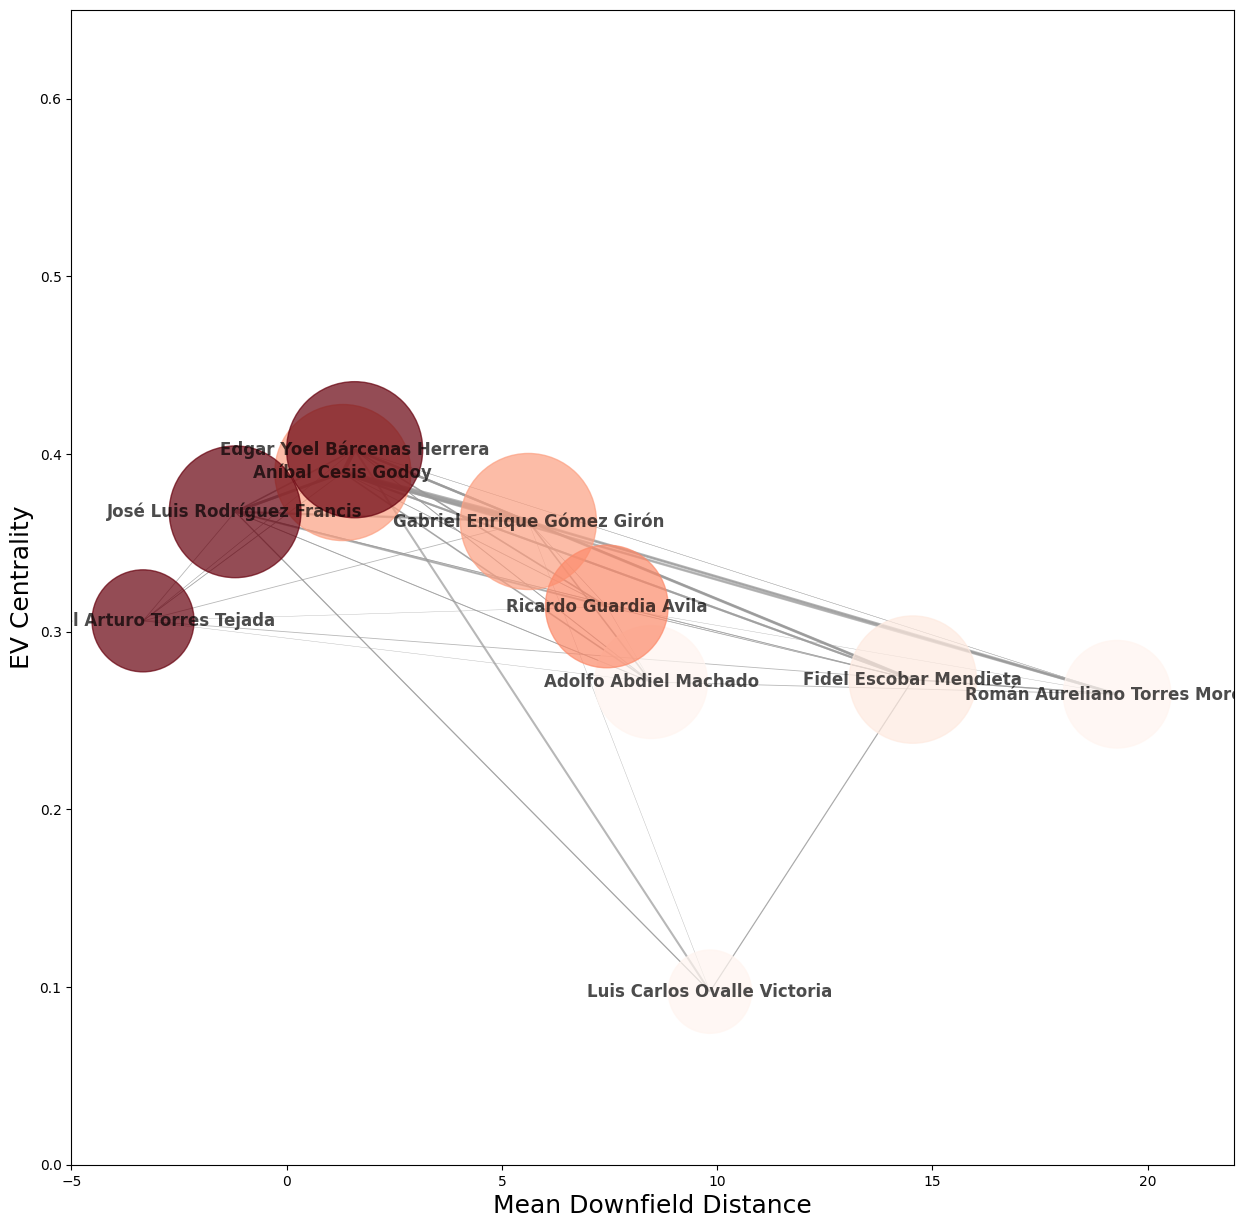

In [43]:
pos = nx.spring_layout(graph)
for p in list(graph.nodes()):
  
    # x pos
    pos[p][0] = passes[passes.player.eq(p)].downfield_dist.mean()
    # y pos
    pos[p][1] = player_metrics[player_metrics.player.eq(p)].ev_centrality.mean()

plt.figure(figsize=(15, 15))
fig, ax = plt.subplots(figsize=(15, 15 ))

# using degree for each node
node_color = [nx.get_node_attributes(graph, 'position_scale')[v] for v in graph]

node_size = [600*nx.get_node_attributes(graph, 'degree')[v] for v in graph]

edge_width = [.3*graph[u][v]['weight'] for u,v in graph.edges()]

nx.draw_networkx(graph, pos, node_size = node_size,  
                 node_color = node_color, alpha = 0.7, arrows=False,
                 with_labels = True, width = edge_width,font_size=12, font_color="black", font_weight="bold",
                 edge_color ='.6', cmap = plt.cm.Reds, ax=ax) 

# off axes
plt.axis('on')
plt.ylim(0, .65)
plt.xlim(-5, 22)
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.xlabel('Mean Downfield Distance', fontsize=18) 
plt.ylabel('EV Centrality', fontsize=18) 

Text(0, 0.5, 'Betweenness')

<Figure size 1500x1500 with 0 Axes>

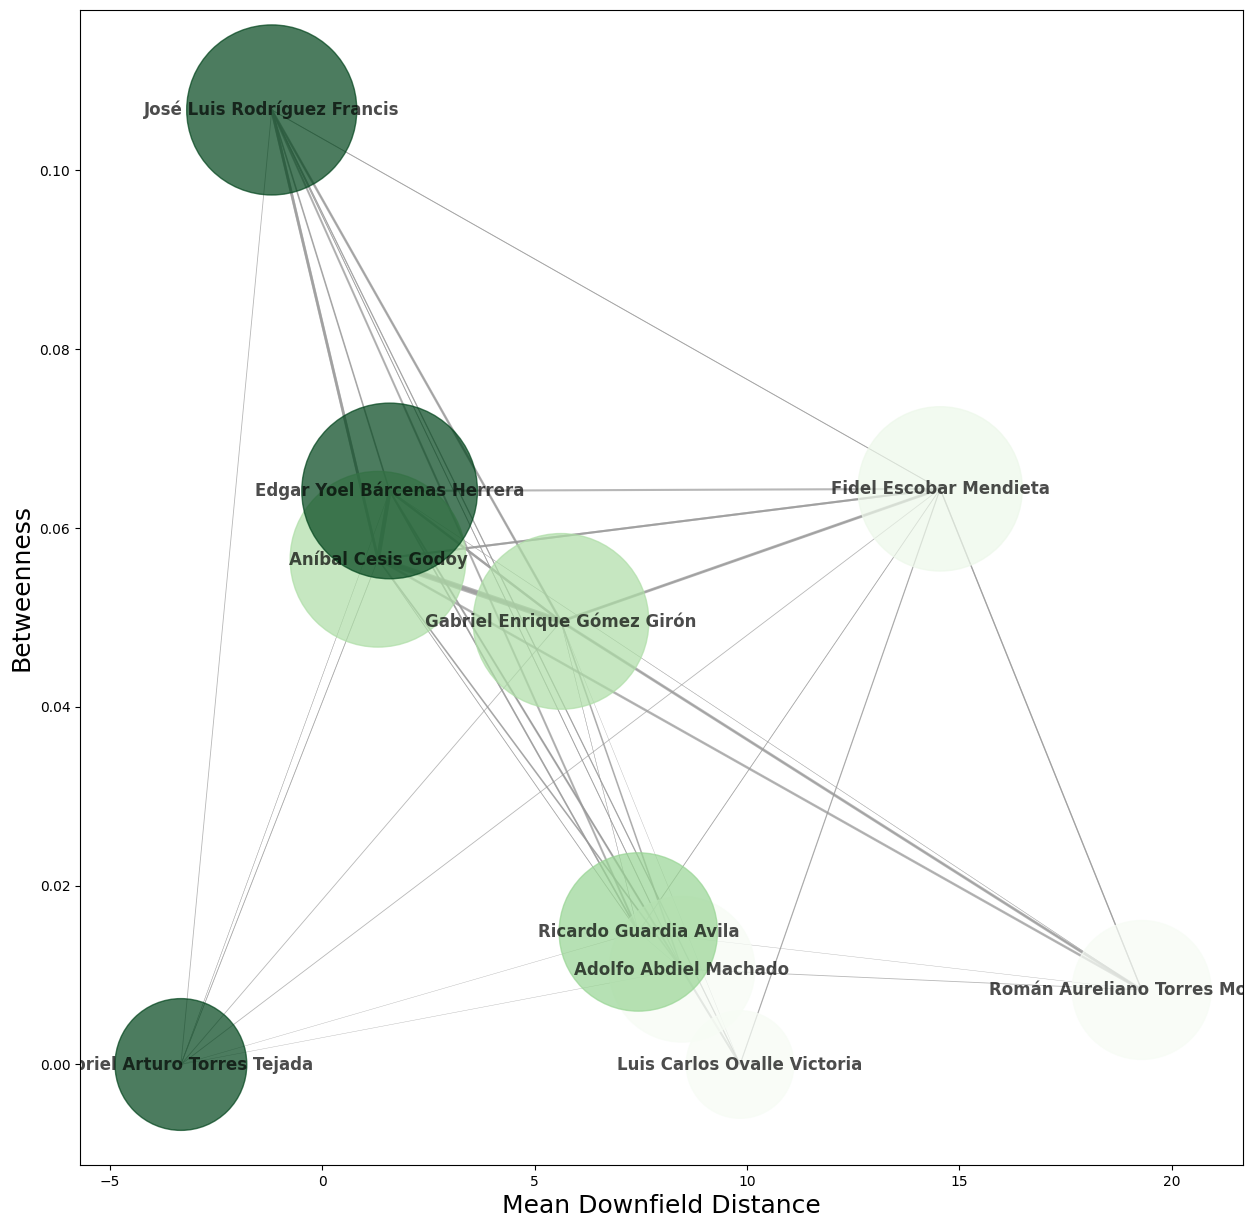

In [44]:
for p in list(graph.nodes()):

    # x pos
    pos[p][0] = passes[passes.player.eq(p)].downfield_dist.mean()
    # y pos
    pos[p][1] = player_metrics[player_metrics.player.eq(p)].betweenness.mean()

plt.figure(figsize=(15, 15))
fig, ax = plt.subplots(figsize=(15, 15))

# using degree for each node
node_color = [nx.get_node_attributes(graph, 'position_scale')[v] for v in graph]

node_size = [1000*nx.get_node_attributes(graph, 'degree')[v] for v in graph]


edge_width = [.3*graph[u][v]['weight'] for u,v in graph.edges()]


nx.draw_networkx(graph, pos, node_size = node_size,  
                 node_color = node_color, alpha = 0.7, arrows=False,
                 with_labels = True, width = edge_width,font_size=12, font_color="black", font_weight="bold",
                 edge_color ='.6', cmap = plt.cm.Greens, ax=ax) 

# off axes
plt.axis('on')
#plt.ylim(0, .008)
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.xlabel('Mean Downfield Distance', fontsize=18) 
plt.ylabel('Betweenness', fontsize=18)

Text(0, 0.5, 'EV Centrality')

<Figure size 1500x1500 with 0 Axes>

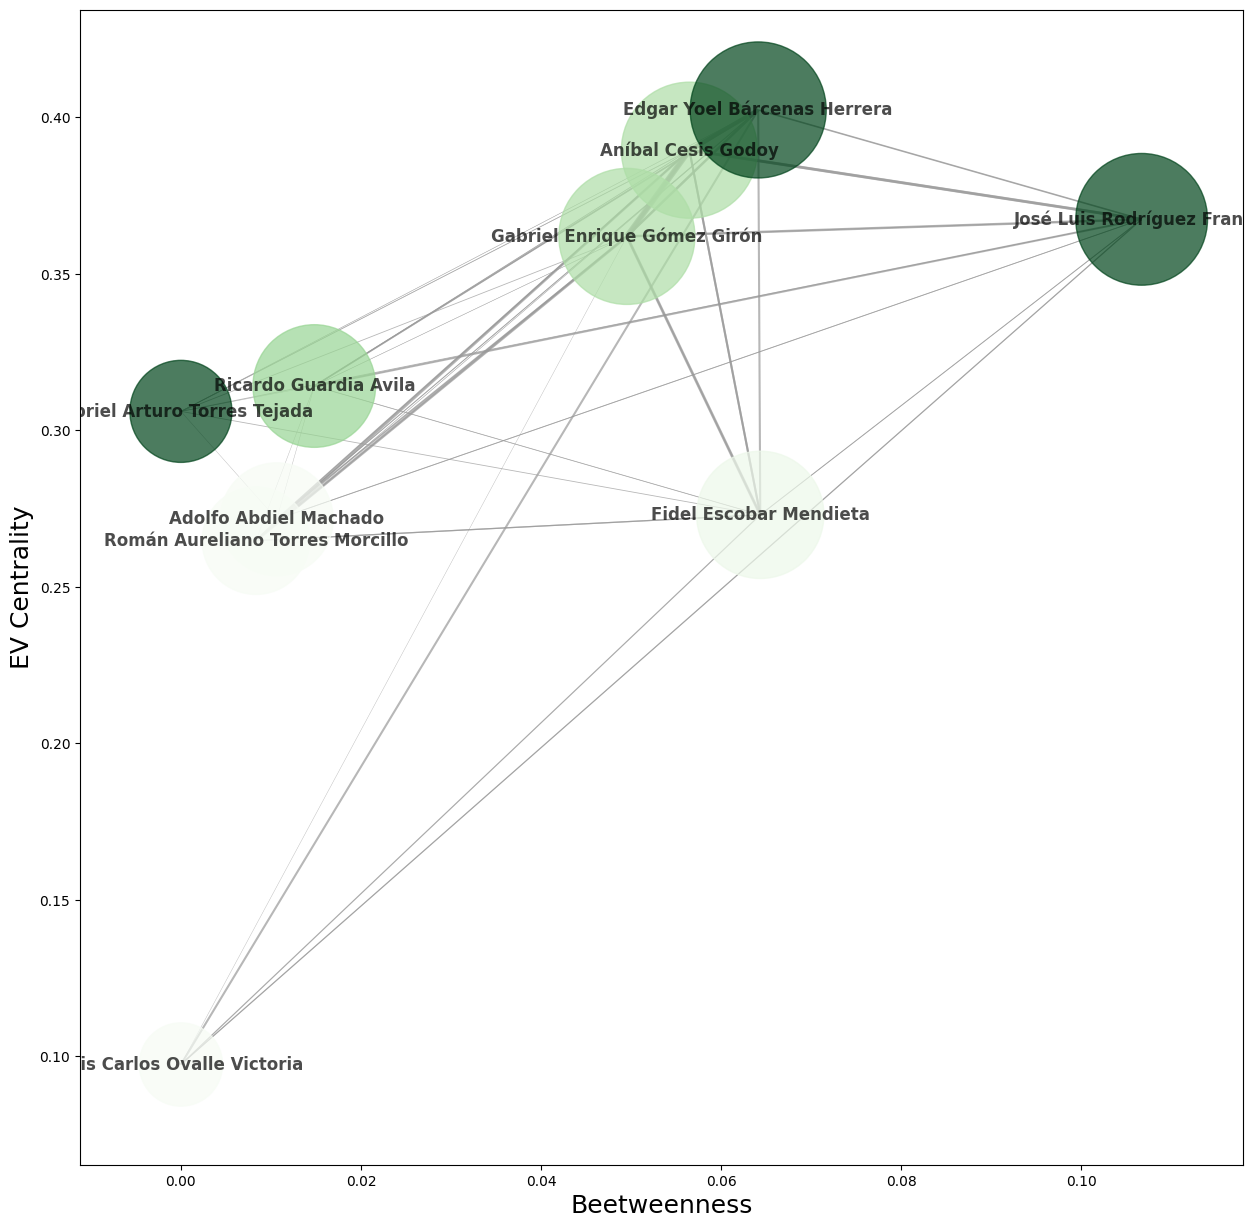

In [45]:
for p in list(graph.nodes()):

    # x pos
    pos[p][0] = player_metrics[player_metrics.player.eq(p)].betweenness
    # y pos
    pos[p][1] = player_metrics[player_metrics.player.eq(p)].ev_centrality

plt.figure(figsize=(15, 15))
fig, ax = plt.subplots(figsize=(15, 15))

# using degree for each node
node_color = [nx.get_node_attributes(graph, 'position_scale')[v] for v in graph]

node_size = [600*nx.get_node_attributes(graph, 'degree')[v] for v in graph]


edge_width = [.3*graph[u][v]['weight'] for u,v in graph.edges()]


nx.draw_networkx(graph, pos, node_size = node_size,  
                 node_color = node_color, alpha = 0.7, arrows=False,
                 with_labels = True, width = edge_width,font_size=12, font_color="black", font_weight="bold",
                 edge_color ='.6', cmap = plt.cm.Greens, ax=ax) 

# off axes
plt.axis('on')
#plt.xlim(0, .008)
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.xlabel('Beetweenness', fontsize=18) 
plt.ylabel('EV Centrality', fontsize=18) 